# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). 


In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql import Window
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier, LogisticRegression,RandomForestClassifier,DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, MinMaxScaler,VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.sql.types import DoubleType

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession \
    .builder \
    .appName("Sparkify churn") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '37981'),
 ('spark.app.id', 'local-1568105544033'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify churn'),
 ('spark.driver.host', '0f8271ba781b')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. We will first load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## load dataset

In [6]:
#load json dataset
df = spark.read.json('mini_sparkify_event_data.json')

In [7]:
#print data schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
#print the first 2 lines to see how the data look like & to get familiar with the data
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

## clean dataset

In [9]:
# as we won't be able to do much with lines with empty userId or sessionId, let's drop the null values for userId and sessionId
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [10]:
# Let's confirm that there are no null values after the cleaning above
df.select([count(when(isnan(c), c)).alias(c) for c in ["userId","sessionId"]]).show()

+------+---------+
|userId|sessionId|
+------+---------+
|     0|        0|
+------+---------+



In [11]:
#how many rows do we have now in the dataset ?
df_valid.count()

286500

In [12]:
#Let's take a look at the userId column

In [13]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [14]:
#even though there are no more NaN values, it seems that there are userId == "", which may cause us problem as well
#let's exclude these empty users from the dataset, probably users who have not registered
df_valid = df_valid.filter(df_valid["userId"] != "")

In [15]:
#after removal, here is the number of remaining rows
total_rows = df_valid.count()
total_rows

278154

# Exploratory Data Analysis


### Define the churn column

In [11]:
#here is the list of the possible actions of the users in the app
df_valid.select("page").dropDuplicates().sort("page").show(truncate=False)


+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



from the list of actions above, it seems that the "Cancellation  Confirmation" is the one we are particularly interested 
to flag churn

In [12]:
#let's take a look at a few examples of users who cancelled their subscription
df_valid.select(['userId', 'firstName','gender','userAgent','location']).\
filter(df_valid['page'] == 'Cancellation Confirmation').sort('userId',ascending=True).show(n=5,truncate=True)

+------+---------+------+--------------------+--------------------+
|userId|firstName|gender|           userAgent|            location|
+------+---------+------+--------------------+--------------------+
|100001|  Delaney|     F|"Mozilla/5.0 (Mac...|Miami-Fort Lauder...|
|100003|   Nevaeh|     F|Mozilla/5.0 (Wind...|Miami-Fort Lauder...|
|100005|    Cason|     M|"Mozilla/5.0 (Mac...|          Monroe, LA|
|100006|    Leyla|     F|"Mozilla/5.0 (Win...|           Flint, MI|
|100007|    Piper|     F|"Mozilla/5.0 (Win...|Little Rock-North...|
+------+---------+------+--------------------+--------------------+
only showing top 5 rows



what were the actions in the app prior to the cancellation ? E.g. for userId = 100001

In [16]:
# first, add a new colum called time to see clearly the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_valid = df_valid.withColumn("time", get_time(df_valid.ts))

In [17]:
#next, let's take a look at the userId 100001
df_valid.select(['time','userId','page','artist','song']).filter(df_valid['userId'] == 100001).sort('time',ascending=False).show(20)

+-------------------+------+--------------------+--------------------+--------------------+
|               time|userId|                page|              artist|                song|
+-------------------+------+--------------------+--------------------+--------------------+
|2018-10-02 16:36:45|100001|Cancellation Conf...|                null|                null|
|2018-10-02 16:34:34|100001|              Cancel|                null|                null|
|2018-10-02 16:34:33|100001|         Roll Advert|                null|                null|
|2018-10-02 16:33:52|100001|            NextSong|            Harmonia|       Sehr kosmisch|
|2018-10-02 16:29:46|100001|                Home|                null|                null|
|2018-10-02 16:29:19|100001|              Logout|                null|                null|
|2018-10-02 16:29:18|100001|            NextSong|           Lady GaGa|           Alejandro|
|2018-10-02 16:24:34|100001|            NextSong|Michael BublÃÂ© ...|Quando_ Qu

In [18]:
#creation of a churn column which will contain 1 if the user cancelled, 0 otherwise
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

df_valid = df_valid.withColumn("Churn", flag_cancellation_event('page'))
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_valid = df_valid.withColumn("Churn",Fsum("Churn").over(windowval))

In [19]:
#let's reuse userId=100001 to confirm that the column Churn is indeed == 1 when the page event is 'Cancellation confirmation'
df_valid.select(['time','userId','page','artist','song','Churn']).filter(df_valid['userId'] == 100001).sort('time',ascending=False).show(10)

+-------------------+------+--------------------+--------------------+--------------------+-----+
|               time|userId|                page|              artist|                song|Churn|
+-------------------+------+--------------------+--------------------+--------------------+-----+
|2018-10-02 16:36:45|100001|Cancellation Conf...|                null|                null|    1|
|2018-10-02 16:34:34|100001|              Cancel|                null|                null|    1|
|2018-10-02 16:34:33|100001|         Roll Advert|                null|                null|    1|
|2018-10-02 16:33:52|100001|            NextSong|            Harmonia|       Sehr kosmisch|    1|
|2018-10-02 16:29:46|100001|                Home|                null|                null|    1|
|2018-10-02 16:29:19|100001|              Logout|                null|                null|    1|
|2018-10-02 16:29:18|100001|            NextSong|           Lady GaGa|           Alejandro|    1|
|2018-10-02 16:24:34

### Data exploration

In [20]:
#let's print again the dataframe schema to highlight the changes we did
df_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- Churn: long (nullable = true)



Now that we defined churn, we gonna perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. 

### General dataset stats

#### general data exploration

In [21]:
print('number of distinct users in sparkify : {}'\
    .format(df_valid.select('userId').drop_duplicates().count()))

number of distinct users in sparkify : 225


In [22]:
print('number of artists present in sparkify : {}'\
      .format(df_valid.select('artist').drop_duplicates().count()))

number of artists present in sparkify : 17656


In [23]:
#total amount of users cancellation
print('total amount of churned users : {}'.format(df_valid.select('userId')\
                                            .where(df_valid.Churn == 1).drop_duplicates().count()))

total amount of churned users : 52


In [24]:
print('percentage of churned users : {}%'\
      .format(round(100*(df_valid.select('userId').where(df_valid.Churn == 1)\
                         .drop_duplicates().count())/df_valid.select('userId')\
                         .drop_duplicates().count())))

percentage of churned users : 23%


#### explore gender distribution for churn

In [25]:
pd_gender = df_valid.select(['userId','Churn','gender']).\
drop_duplicates(["userId","Churn",'gender']).groupby(["Churn","gender"]).count().toPandas()

In [26]:
pd_gender

,Churn,gender,count
0,0,F,84
1,1,M,32
2,1,F,20
3,0,M,89


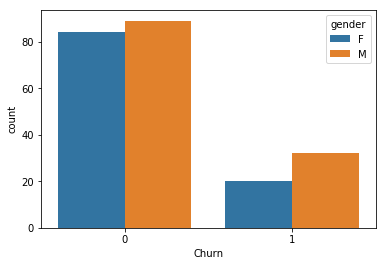

In [27]:
sns.barplot(x='Churn',y='count',hue='gender',data=pd_gender)

generally speaking , there are more men than women using the service, but as well more men likely to churn

#### explore level (paid or free) distribution for churn

In [28]:
pd_item = df_valid.select(['userId','Churn','level']).\
drop_duplicates(["userId","Churn",'level']).groupby(["Churn","level"]).count().toPandas()

In [29]:
pd_item

,Churn,level,count
0,1,paid,36
1,1,free,46
2,0,free,149
3,0,paid,129


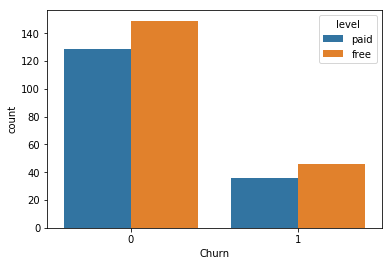

In [30]:
sns.barplot(x='Churn',y='count',hue='level',data=pd_item)

churned users are present more with free than paid users

#### general distribution of events in the app between churned and active users

In [31]:
#let's create 2 pandas datasets ; one for churned users, one for active users
churned_users = df_valid.select(['userId','page']).where(df_valid.Churn == 1).groupby('page').agg(count("userId")).toPandas()
active_users = df_valid.select(['userId','page']).where(df_valid.Churn == 0).groupby('page').agg(count("userId")).toPandas()

In [32]:
active_users['Churned'] = 'No'
active_users['percent(userId)'] = round(100*active_users['count(userId)']/np.sum(active_users['count(userId)']),1)
active_users = active_users.drop(labels=['count(userId)'],axis=1)
active_users

,page,Churned,percent(userId)
0,Submit Downgrade,No,0.0
1,Thumbs Down,No,0.9
2,Home,No,3.6
3,Downgrade,No,0.7
4,Roll Advert,No,1.3
5,Logout,No,1.1
6,Save Settings,No,0.1
7,About,No,0.2
8,Settings,No,0.5
9,Add to Playlist,No,2.4


In [33]:
churned_users['percent(userId)'] = round(100*churned_users['count(userId)']/np.sum(churned_users['count(userId)']),1)
churned_users['Churned'] = 'Yes'
churned_users = churned_users.drop(labels=['count(userId)'],axis=1)
churned_users

,page,percent(userId),Churned
0,Cancel,0.1,Yes
1,Submit Downgrade,0.0,Yes
2,Thumbs Down,1.1,Yes
3,Home,3.7,Yes
4,Downgrade,0.8,Yes
5,Roll Advert,2.2,Yes
6,Logout,1.2,Yes
7,Save Settings,0.1,Yes
8,Cancellation Confirmation,0.1,Yes
9,About,0.1,Yes


In [34]:
concat_users = pd.concat([churned_users,active_users],sort=False)

In [35]:
concat_users

,page,percent(userId),Churned
0,Cancel,0.1,Yes
1,Submit Downgrade,0.0,Yes
2,Thumbs Down,1.1,Yes
3,Home,3.7,Yes
4,Downgrade,0.8,Yes
5,Roll Advert,2.2,Yes
6,Logout,1.2,Yes
7,Save Settings,0.1,Yes
8,Cancellation Confirmation,0.1,Yes
9,About,0.1,Yes


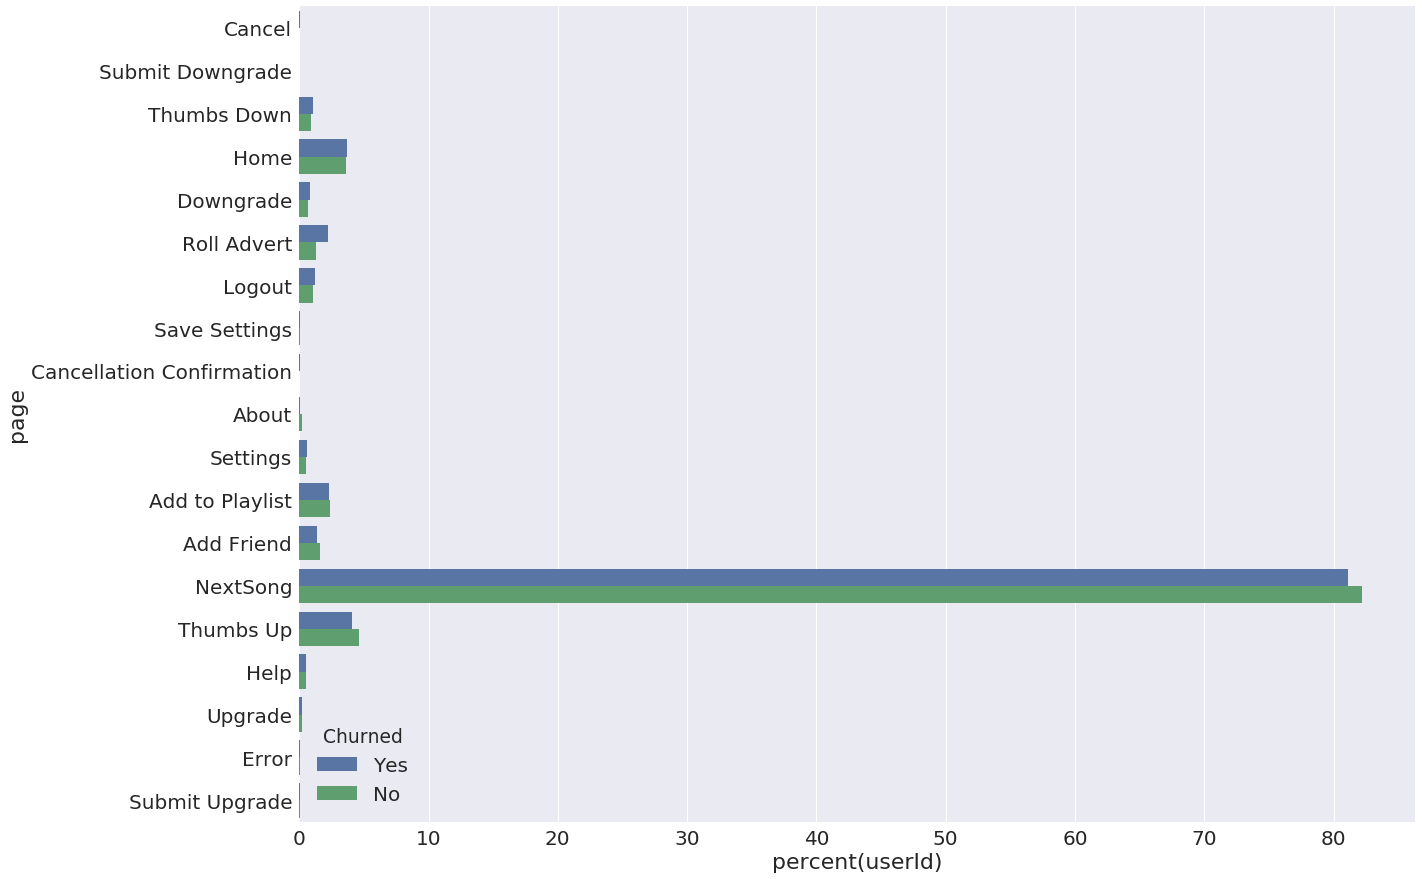

In [36]:
fig=plt.figure(figsize=(20,15))
sns.set(font_scale=2)
snsbp = sns.barplot(data=concat_users,x='percent(userId)',y='page',capsize=0.2,hue='Churned');
snsbp.set_xticklabels(snsbp.get_xticklabels(), rotation=90,minor=True);



#### analysis based on time series (hours, days)

In [37]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m"))

df_valid = df_valid.withColumn("hour", get_hour(df_valid.ts))
df_valid = df_valid.withColumn("weekday", get_weekday(df_valid.ts))
df_valid = df_valid.withColumn("month", get_month(df_valid.ts))

In [38]:
df_valid.select(['userId','firstName','hour','weekday','month']).where(df_valid.userId == 30).show()

+------+---------+----+-------+-----+
|userId|firstName|hour|weekday|month|
+------+---------+----+-------+-----+
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   0|      1|   10|
|    30|    Colin|   1|      1|   10|
|    30|    Colin|   1|      1|   10|
|    30|    Colin|   1|      1|   10|
+------+---------+----+-------+-----+
only showing top 20 rows



In [39]:
songs_in_hour = df_valid.filter(df_valid.page == "NextSong").groupby(df_valid.hour).count().orderBy(df_valid.hour.cast("float"))

In [40]:
songs_in_hour.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
|  20|10856|
|  21|10458|
|  22|10122|
|  23| 9630|
+----+-----+



In [41]:
songs_in_weekday = df_valid.filter(df_valid.page == "NextSong").groupby(df_valid.weekday).count().orderBy(df_valid.weekday.cast("float"))

In [42]:
songs_in_weekday.show()

+-------+-----+
|weekday|count|
+-------+-----+
|      0|17370|
|      1|35373|
|      2|38830|
|      3|37675|
|      4|36300|
|      5|39514|
|      6|23046|
+-------+-----+



In [43]:
songs_churned_hour = df_valid[df_valid.Churn == 1].filter(df_valid.page == 'NextSong').groupby(df_valid.hour).count().orderBy(df_valid.hour.cast("float")).toPandas()
songs_active_hour = df_valid[df_valid.Churn == 0].filter(df_valid.page == 'NextSong').groupby(df_valid.hour).count().orderBy(df_valid.hour.cast("float")).toPandas()
songs_churned_hour['Churned'] = 'Yes'
songs_active_hour['Churned'] = 'No'
concat_songs_hour_users = pd.concat([songs_active_hour,songs_churned_hour],sort=False)

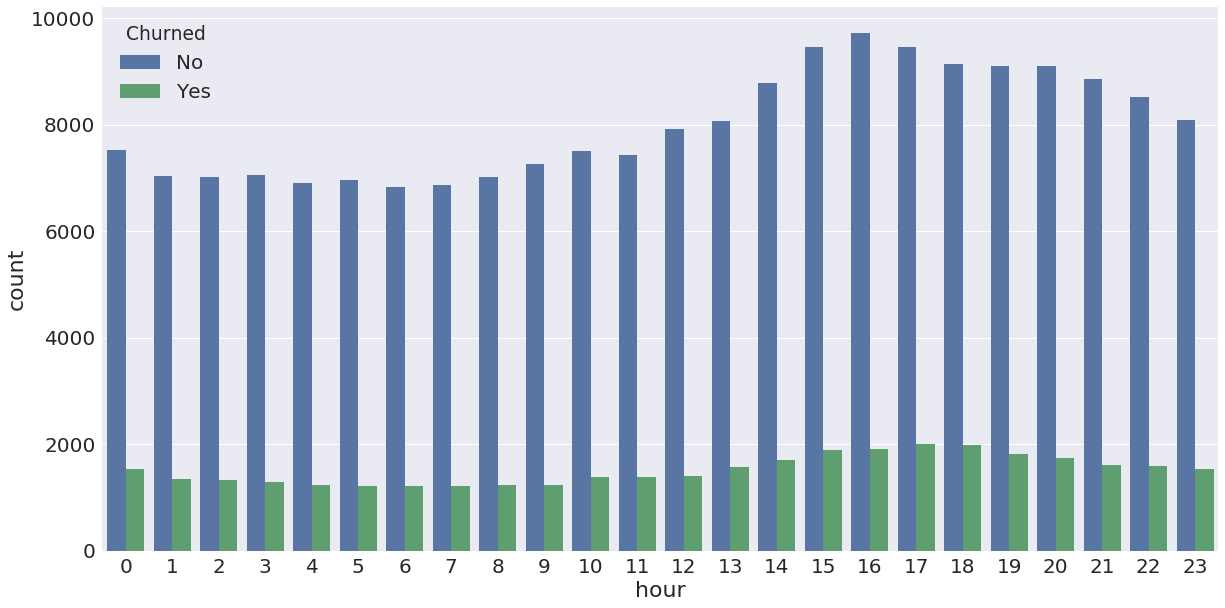

In [44]:
fig=plt.figure(figsize=(20,10))
sns.set(font_scale=2)
snsbp = sns.barplot(data=concat_songs_hour_users,x='hour',y='count',capsize=0.2,hue='Churned',\
                    order=["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23"]);
snsbp.set_xticklabels(snsbp.get_xticklabels(), rotation=90,minor=True);

Churned users seem to be more active in the afternoon until beginning of the evening, while the paid users seems to be more activte even during the evening - midnight

In [45]:
songs_churned_weekday = df_valid[df_valid.Churn == 1].filter(df_valid.page == 'NextSong').groupby(df_valid.weekday).count().orderBy(df_valid.weekday.cast("float")).toPandas()
songs_active_weekday = df_valid[df_valid.Churn == 0].filter(df_valid.page == 'NextSong').groupby(df_valid.weekday).count().orderBy(df_valid.weekday.cast("float")).toPandas()
songs_churned_weekday['Churned'] = 'Yes'
songs_active_weekday['Churned'] = 'No'
concat_songs_wd_users = pd.concat([songs_active_weekday,songs_churned_weekday],sort=False)

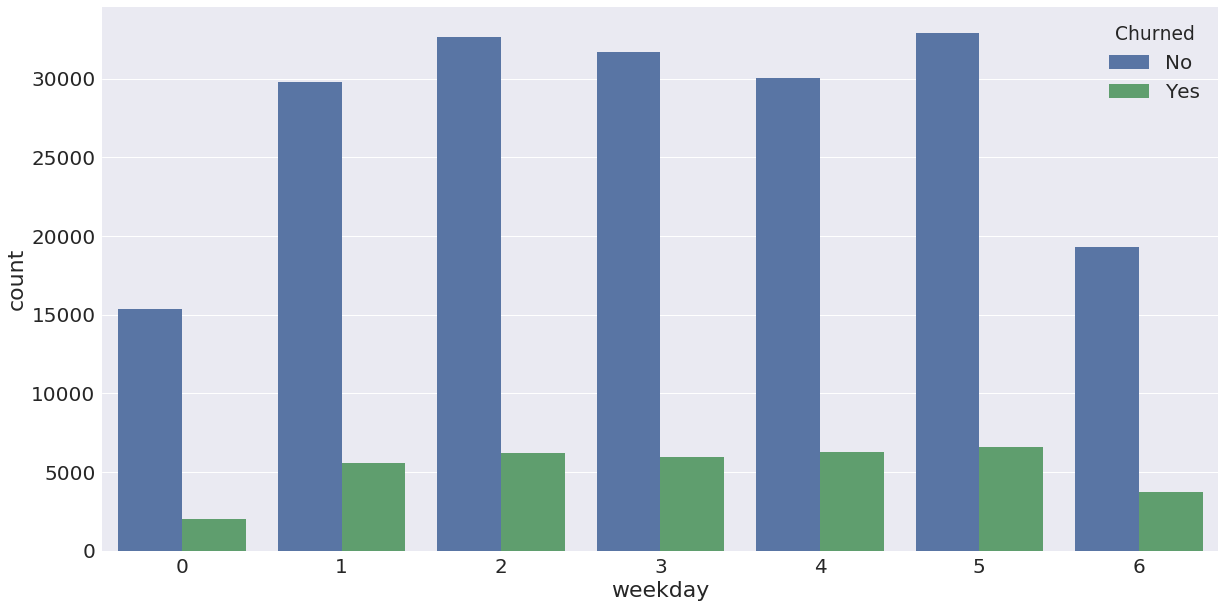

In [46]:
fig=plt.figure(figsize=(20,10))
sns.set(font_scale=2)
snsbp = sns.barplot(data=concat_songs_wd_users,x='weekday',y='count',capsize=0.2,hue='Churned',) 
                    
snsbp.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=90,minor=True);

For churned users, there isn't such a peak of consumption on Saturday like for the paid users

# Feature Engineering
In this section we are going to engineer a few features that will be used to train the machine learning model

1) gender

In [98]:
df_gender = df_valid.select(['userId','gender']).dropDuplicates(['userId']).toPandas()
df_gender = df_gender.replace({'F' : 0, 'M' : 1})
df_gender.head()

,userId,gender
0,100010,0
1,200002,1
2,125,1
3,124,0
4,51,1


2) payment level (paid or free)

In [99]:
df_level = df_valid.select(['userId','level']).dropDuplicates(['userId']).toPandas()
df_level.replace(['paid','free'],[1,0],inplace=True)
df_level.head()

,userId,level
0,100010,0
1,200002,0
2,125,0
3,124,1
4,51,1


3) thumbs up / down

In [100]:
df_thumbsup = df_valid.select(['userId','page']).filter(df_valid.page == 'Thumbs Up').\
                groupby('userId').count().toPandas()
df_thumbsup.rename(columns={'count':'thumbsup'},inplace=True)
df_thumbsup.head()

,userId,thumbsup
0,100010,17
1,200002,21
2,51,100
3,124,171
4,7,7


In [101]:
df_thumbsdown = df_valid.select(['userId','page']).filter(df_valid.page == 'Thumbs Down').\
                groupby('userId').count().toPandas()
df_thumbsdown.rename(columns={'count':'thumbsdown'},inplace=True)
df_thumbsdown.head()

,userId,thumbsdown
0,100010,5
1,200002,6
2,51,21
3,124,41
4,7,1


4) Number total of songs played by the user since the registration

In [102]:
df_songs = df_valid.select(['userId','song']).groupby('userId').count().toPandas()
df_songs.rename(columns={"count":"nbsongs"},inplace=True)
df_songs.head()

,userId,nbsongs
0,100010,381
1,200002,474
2,125,11
3,51,2464
4,124,4825


5) Number of day spent using the service since registration date

In [103]:
df_timesincereg = df_valid.withColumn("timesincereg" , (ds['ts']-ds['registration'])/(1000*60*60*24))\
                    .select(['userId','timesincereg']).groupby('userId').max('timesincereg').toPandas()
df_timesincereg.head()

,userId,max(timesincereg)
0,100010,55.643657
1,200002,70.074630
2,125,71.316887
3,51,19.455845
4,124,131.555914


6) average number of songs played per session per userId

In [104]:
df_sessions_songs = df_valid.select(['userId','song','sessionId'])\
                    .groupby(['userId','sessionId'])\
                    .count().groupby(['userId']).agg({'count':'avg'}).toPandas()
df_sessions_songs.rename(columns={"avg(count)":"average_songs"},inplace=True)
df_sessions_songs.head()

,userId,average_songs
0,100010,54.428571
1,200002,79.000000
2,125,11.000000
3,51,246.400000
4,124,166.379310


7) number of songs added by the user to playlist

In [105]:
df_playlist = df_valid.select(['userId','page'])\
                .filter(df_valid.page == 'Add to Playlist')\
                .groupby('userId').count().toPandas()
df_playlist.rename(columns={'count':'addtoplaylist'},inplace=True)
df_playlist.head()

,userId,addtoplaylist
0,100010,7
1,200002,8
2,51,52
3,124,118
4,7,5


8) Number of friends added to the service

In [106]:
df_friends = df_valid.select(['userId','page'])\
            .filter(df_valid.page == 'Add Friend')\
            .groupby('userId').count().toPandas()
df_friends.rename(columns={'count':'addedfriends'},inplace=True)
df_friends.head()

,userId,addedfriends
0,100010,4
1,200002,4
2,51,28
3,124,74
4,7,1


9) proportion of roll adverts

In [111]:
df_roll = df_valid.select(['userId','page'])\
            .filter(df_valid.page == 'Roll Advert')\
            .groupby('userId').count().toPandas()
df_roll.rename(columns={'count':'rolladv'},inplace=True)
df_roll.head()

,userId,rolladv
0,100010,52
1,200002,7
2,125,1
3,7,16
4,124,4


Last but not least, our label = churned users

In [112]:
df_churn = df_valid.select(['userId','Churn']).dropDuplicates().toPandas()
df_churn.head()

,userId,Churn
0,100010,0
1,200002,0
2,125,1
3,124,0
4,51,1


In [113]:
#here we are creating a final version of the dataframe, merging together all features
df_final = pd.merge(df_gender,df_level,how='left',on='userId')
df_final = pd.merge(df_final,df_thumbsup,how='left',on='userId')
df_final = pd.merge(df_final,df_thumbsdown,how='left',on='userId')
df_final = pd.merge(df_final,df_songs,how='left',on='userId')
df_final = pd.merge(df_final,df_timesincereg,how='left',on='userId')
df_final = pd.merge(df_final,df_sessions_songs,how='left',on='userId')
df_final = pd.merge(df_final,df_playlist,how='left',on='userId')
df_final = pd.merge(df_final,df_friends,how='left',on='userId')
df_final = pd.merge(df_final,df_roll,how='left',on='userId')

In [114]:
df_final.head()

,userId,gender,level,thumbsup,thumbsdown,nbsongs,max(timesincereg),average_songs,addtoplaylist,addedfriends,rolladv
0,100010,0,0,17.0,5.0,381,55.643657,54.428571,7.0,4.0,52.0
1,200002,1,0,21.0,6.0,474,70.074630,79.000000,8.0,4.0,7.0
2,125,1,0,NaN,NaN,11,71.316887,11.000000,NaN,NaN,1.0
3,124,0,1,171.0,41.0,4825,131.555914,166.379310,118.0,74.0,4.0
4,51,1,1,100.0,21.0,2464,19.455845,246.400000,52.0,28.0,NaN


In [115]:
#add churn as the last column
df_final = pd.merge(df_final,df_churn,how='left',on='userId')
df_final.head()

,userId,gender,level,thumbsup,thumbsdown,nbsongs,max(timesincereg),average_songs,addtoplaylist,addedfriends,rolladv,Churn
0,100010,0,0,17.0,5.0,381,55.643657,54.428571,7.0,4.0,52.0,0
1,200002,1,0,21.0,6.0,474,70.074630,79.000000,8.0,4.0,7.0,0
2,125,1,0,NaN,NaN,11,71.316887,11.000000,NaN,NaN,1.0,1
3,124,0,1,171.0,41.0,4825,131.555914,166.379310,118.0,74.0,4.0,0
4,51,1,1,100.0,21.0,2464,19.455845,246.400000,52.0,28.0,NaN,1


In [116]:
#dropping now the userId column as it was only needed to concatenate the dataframes, we won't use it as a feature to train the model
df_final.drop(['userId'],axis=1,inplace=True)
df_final.head()

,gender,level,thumbsup,thumbsdown,nbsongs,max(timesincereg),average_songs,addtoplaylist,addedfriends,rolladv,Churn
0,0,0,17.0,5.0,381,55.643657,54.428571,7.0,4.0,52.0,0
1,1,0,21.0,6.0,474,70.074630,79.000000,8.0,4.0,7.0,0
2,1,0,NaN,NaN,11,71.316887,11.000000,NaN,NaN,1.0,1
3,0,1,171.0,41.0,4825,131.555914,166.379310,118.0,74.0,4.0,0
4,1,1,100.0,21.0,2464,19.455845,246.400000,52.0,28.0,NaN,1


In [117]:
#there are NaN values that we need to take care of before starting the ML analysis
df_final.isna().sum().sort_values(ascending=False)

thumbsdown           22
addedfriends         19
rolladv              18
addtoplaylist        10
thumbsup              5
Churn                 0
average_songs         0
max(timesincereg)     0
nbsongs               0
level                 0
gender                0
dtype: int64

thumbsdown , addedfriends ,rolladv ,addtoplaylist,thumbsup contains NaN values for users who didn't used these options in the app. The easiest way to deal with these values is to replace all NaN by 0 as the users didn't use those anyway

In [118]:
df_final.fillna(value=0,inplace=True)

In [4]:
#last but not least, create a function to quickly recreate the df_final dataframe if needed
def create_dataframe(jsonfile):
    '''
    INPUT:
        jsonfile. String, path to the jsonfile extract
    OUTPUT:
        df_final. Pandas dataframe containing ready to go dataframe with all features
        df_spark_final. Spark dataframe based on df_final pandas dataframe. For spark ml usage
    '''
    spark = SparkSession \
    .builder \
    .appName("Sparkify churn") \
    .getOrCreate()
    
    df = spark.read.json(jsonfile)    
    df = df.filter(df["userId"] != "")
    
    #creation of a churn column which will contain 1 if the user cancelled, 0 otherwise
    flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn("Churn", flag_cancellation_event('page'))
    windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    df = df.withColumn("Churn",Fsum("Churn").over(windowval))
    
    df_gender = df.select(['userId','gender']).dropDuplicates(['userId']).toPandas()
    df_gender = df_gender.replace({'F' : 0, 'M' : 1})
    
    
    df_level = df.select(['userId','level']).dropDuplicates(['userId']).toPandas()
    df_level.replace(['paid','free'],[1,0],inplace=True)
    
    df_thumbsup = df.select(['userId','page']).filter(df.page == 'Thumbs Up').\
                groupby('userId').count().toPandas()
    df_thumbsup.rename(columns={'count':'thumbsup'},inplace=True)
    
    df_thumbsdown = df.select(['userId','page']).filter(df.page == 'Thumbs Down').\
                groupby('userId').count().toPandas()
    df_thumbsdown.rename(columns={'count':'thumbsdown'},inplace=True)

    df_songs = df.select(['userId','song']).groupby('userId').count().toPandas()
    df_songs.rename(columns={"count":"nbsongs"},inplace=True)
    
    df_timesincereg = df_valid.withColumn("timesincereg" , (df_valid['ts']-df_valid['registration'])/(1000*60*60*24))\
                    .select(['userId','timesincereg']).groupby('userId').max('timesincereg').toPandas()
        
    df_sessions_songs = df.select(['userId','song','sessionId'])\
                    .groupby(['userId','sessionId'])\
                    .count().groupby(['userId']).agg({'count':'avg'}).toPandas()
    df_sessions_songs.rename(columns={"avg(count)":"average_songs"},inplace=True)
    
    df_playlist = df.select(['userId','page'])\
                .filter(df.page == 'Add to Playlist')\
                .groupby('userId').count().toPandas()
    df_playlist.rename(columns={'count':'addtoplaylist'},inplace=True)
    
    df_friends = df.select(['userId','page'])\
            .filter(df.page == 'Add Friend')\
            .groupby('userId').count().toPandas()
    df_friends.rename(columns={'count':'addedfriends'},inplace=True)
    
    df_roll = df.select(['userId','page'])\
            .filter(df.page == 'Roll Advert')\
            .groupby('userId').count().toPandas()
    df_roll.rename(columns={'count':'rolladv'},inplace=True)
    
    df_churn = df.select(['userId','Churn']).dropDuplicates().toPandas()
    
    
    df_final = pd.merge(df_gender,df_level,how='left',on='userId')
    df_final = pd.merge(df_final,df_thumbsup,how='left',on='userId')
    df_final = pd.merge(df_final,df_thumbsdown,how='left',on='userId')
    df_final = pd.merge(df_final,df_songs,how='left',on='userId')
    df_final = pd.merge(df_final,df_timesincereg,how='left',on='userId')
    df_final = pd.merge(df_final,df_sessions_songs,how='left',on='userId')
    df_final = pd.merge(df_final,df_playlist,how='left',on='userId')
    df_final = pd.merge(df_final,df_friends,how='left',on='userId')
    df_final = pd.merge(df_final,df_roll,how='left',on='userId')
    df_final = pd.merge(df_final,df_churn,how='left',on='userId')
    
    
    #dropping now the userId column as it was only needed to concatenate the dataframes, we won't use it as a feature to train the model
    df_final.drop(['userId'],axis=1,inplace=True)
    df_final.fillna(value=0,inplace=True)
    
    #let's export the df_final pandas to csv to be able to read it next as a spark df
    df_final.to_csv('export_final.csv',header=True,index=False)
    df_spark_final = spark.read.csv('export_final.csv',header=True)
    
    #unfortunately, all the columns are now non numerical (string), so we need to convert them back to double
    for c in df_spark_final.columns:
        df_spark_final = df_spark_final.withColumn(c,df_spark_final[c].cast(DoubleType()))
    df_spark_final = df_spark_final.withColumnRenamed("Churn","label")    
    
    return df_final,df_spark_final
    

In [16]:
df_final, df_spark_final = create_dataframe('mini_sparkify_event_data.json')

In [17]:
df_final.head()

,gender,level,thumbsup,thumbsdown,nbsongs,max(timesincereg),average_songs,addtoplaylist,addedfriends,rolladv,Churn
0,0,0,17.0,5.0,381,55.643657,54.428571,7.0,4.0,52.0,0
1,1,0,21.0,6.0,474,70.074630,79.000000,8.0,4.0,7.0,0
2,1,0,0.0,0.0,11,71.316887,11.000000,0.0,0.0,1.0,1
3,0,1,171.0,41.0,4825,131.555914,166.379310,118.0,74.0,4.0,0
4,1,1,100.0,21.0,2464,19.455845,246.400000,52.0,28.0,0.0,1


In [18]:
df_spark_final

DataFrame[gender: double, level: double, thumbsup: double, thumbsdown: double, nbsongs: double, max(timesincereg): double, average_songs: double, addtoplaylist: double, addedfriends: double, rolladv: double, label: double]

# Modeling
In this part, we will train and test several ML models to determine the one which is giving the highest F1 score. The reason why we will use the F1 score as a metric is that the churned users proportion is quite low in the big dataset (285k records), so drawing conclusion on accuracy alone on such a small group of rows won't give a fair measurement and could even lead us to wrong assessment.

In order to use spark ml, one need again a spark dataframe format and not a pandas dataframe

In [19]:
#loading spark dataframe
_, df_spark_final = create_dataframe('mini_sparkify_event_data.json')

In [20]:
df_spark_final

DataFrame[gender: double, level: double, thumbsup: double, thumbsdown: double, nbsongs: double, max(timesincereg): double, average_songs: double, addtoplaylist: double, addedfriends: double, rolladv: double, label: double]

In [21]:
# Split the data into train and test sets (80%/20% split)
train_data, test_data = df_spark_final.randomSplit([.8,.2],seed=42)

In [22]:
#spark ml requires a vector of features, let's create one with our columns (excluding 'Churn' obviously)
assembler = VectorAssembler(inputCols=df_spark_final.columns[:-1], outputCol="features")

In [23]:
#scale the data : define the standard scaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledfeatures")

In [24]:
clf_A = GBTClassifier(featuresCol="scaledfeatures",labelCol="label")
clf_B = RandomForestClassifier(featuresCol="scaledfeatures",labelCol="label")
clf_C = DecisionTreeClassifier(featuresCol="scaledfeatures",labelCol="label")

classifiers = {'GBT' : clf_A,'RandomForest' : clf_B, 'DecisionTree' : clf_C}

In [28]:
#using gridsearch to determine the optimum parameters for the algorithms
parametersGrid_A = (ParamGridBuilder()
             .addGrid(clf_A.maxDepth, [8, 16,20])
             .addGrid(clf_A.maxBins, [8 ,16,20])
             .addGrid(clf_A.maxIter, [10, 15])
             .build())

parametersGrid_B = (ParamGridBuilder()
             .addGrid(clf_B.maxDepth, [8, 16,20])
             .addGrid(clf_B.maxBins, [8, 16, 20])
             .addGrid(clf_B.impurity, ['gini','entropy'])
             .build())

parametersGrid_C = (ParamGridBuilder()
             .addGrid(clf_C.maxDepth, [8, 16,20])
             .addGrid(clf_C.maxBins, [8,16,20])
             .addGrid(clf_C.impurity, ['gini','entropy'])
             .build())

params_grid = {'GBT' : parametersGrid_A, 'RandomForest' : parametersGrid_B, 'DecisionTree' : parametersGrid_C}

In [32]:
def compare_models():
    '''
    compare models printing F1 score
    INPUT:
    OUTPUT:
        best_models. dictionary with model as a key and F1 score as the value
    '''
    best_models={}
    for k in classifiers.keys():
        
        #chaining assembler, scaler and classifier in a pipeline
        pipeline = Pipeline(stages=[assembler,scaler,classifiers[k]])
        evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol="prediction",metricName='f1')
        #use k-folds cross validation to add oversampling (k = 5)
        model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params_grid[k],
        evaluator=evaluator,
        numFolds=5,
        )
        trained_model = model.fit(train_data)
        preds = trained_model.transform(test_data)
        print('predictions for model {} : f1 = {}'.format(k,evaluator.evaluate(preds)))
        best_models[k] = trained_model.bestModel
        
    return best_models

In [33]:
best_models = compare_models()

predictions for model GBT : f1 = 0.7912280701754386
predictions for model RandomForest : f1 = 0.741852487135506
predictions for model DecisionTree : f1 = 0.8188405797101449


In [35]:
best_models

{'GBT': PipelineModel_61d05e81f919,
 'RandomForest': PipelineModel_51d91087db9c,
 'DecisionTree': PipelineModel_df6c7d40f3ab}

From the analysis above, the DecisionTreeClassifier (DecisionTree) seems to give the highest F1 score, so we will keep this model moving forward

In [36]:
DT_best_model = best_models['DecisionTree']

In [37]:
DT_best_model.save("dt_bestmodel.model")

In [38]:
#Now that we have the trained model,we can compute the relative importance of each features in the F1 score

In [39]:
#Here is the list of weights for each features
featuresimp = DT_best_model.stages[2].featureImportances.values.tolist()
featuresimp

[0.01574967358189468,
 0.05654882800356472,
 0.11569710414641375,
 0.12963811945216797,
 0.04422261288092781,
 0.3248676899677471,
 0.050398955462062946,
 0.051479221534667226,
 0.04195602699676053,
 0.16944176797379334]

In [40]:
#and here are the features 
features = df_final.columns[:-1].values.tolist()
features

['gender',
 'level',
 'thumbsup',
 'thumbsdown',
 'nbsongs',
 'max(timesincereg)',
 'average_songs',
 'addtoplaylist',
 'addedfriends',
 'rolladv']

In [41]:
df_featuresimp = pd.DataFrame({'features':features,'featuresimp':featuresimp})

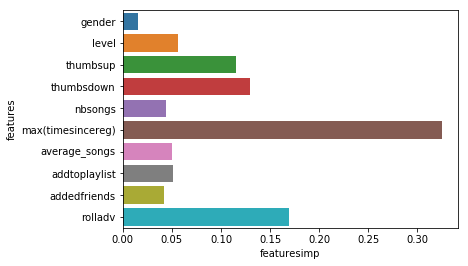

In [42]:
sns.barplot(y='features',x='featuresimp',data=df_featuresimp)

# Conclusion

# Reflection

This was my first exposure to the spark ml framework and it took me quite a bit of time to adapt and to learn how to use it. Once I was familiar, I could make the connection with pandas and sklearn, as at the end these frameworks are similar. I was though a bit disappointed by the documentation available for spark which seems to be less described compared to pandas and sklearn, maybe because of the popularity of these last two.
It was interesting as well to understand how the processing of "big data" works in the background, with the full capabilities of the Spark framework. It actually gave me the idea to start experimenting more in Azure databricks (which is available in my company) on some other real work examples and "big data" accessible from azure datalake (ex: prediction of sales)

# Improvements

As always, "all models are wrong and some are usefull". So there are certainly room for improvement here as well.
I could have played more with the hyperparameters tuning using gridsearch, probably playing with the deepth of the trees, or changing the loss function maybe. What would certainly help better is simply to download more data from the main dataset to give the chance to the algorithm to better learn. Last but not least we could have added more features like geographical data for instance (as we have the location column in the dataset)